In [1]:
import numpy as np
import cv2
import os
from os import listdir
from os.path import isfile, isdir, join
from matplotlib import pyplot as plt
from PIL import Image

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import keras
from RegModels import GreenUnet160, GreenUnet160b, GreenUnet320
from ImageProcessor import Merge, Split

Using plaidml.keras.backend backend.


### Training Phase

In [3]:
train_x = np.load('C:/Users/tmyda/Documents/UAV_reg/Splitted_training_data/NIR2G_160_train_x.npy')
train_y = np.load('C:/Users/tmyda/Documents/UAV_reg/Splitted_training_data/NIR2G_160_train_y.npy')

print('X.shape')
print(train_x.shape)
print('Y.shape')
print(train_y.shape)

X.shape
(4795, 160, 160, 1)
Y.shape
(4795, 160, 160, 1)


In [2]:
#model = GreenUnet160()
model = GreenUnet160b()
#model = GreenUnet320()
model.model().summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 160, 160, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 80, 80, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [4]:
opt = keras.optimizers.Adam()
model.compile(loss='mse', optimizer=opt)
history = model.fit(train_x, train_y, batch_size=64, epochs=100, validation_split=0.2)


Train on 3836 samples, validate on 959 samples
Epoch 1/100


INFO:plaidml:Analyzing Ops: 399 of 950 operations complete
INFO:plaidml:Analyzing Ops: 809 of 950 operations complete


3776/3836 [============================>.] - ETA: 5s - loss: 0.0203 

INFO:plaidml:Analyzing Ops: 388 of 951 operations complete
INFO:plaidml:Analyzing Ops: 630 of 951 operations complete


3836/3836 [==============================] - 387s 101ms/step - loss: 0.0202 - val_loss: 0.0178
Epoch 2/100
3836/3836 [==============================] - 315s 82ms/step - loss: 0.0167 - val_loss: 0.0169
Epoch 3/100
3836/3836 [==============================] - 313s 82ms/step - loss: 0.0160 - val_loss: 0.0153
Epoch 4/100
3836/3836 [==============================] - 315s 82ms/step - loss: 0.0150 - val_loss: 0.0140
Epoch 5/100
3836/3836 [==============================] - 310s 81ms/step - loss: 0.0139 - val_loss: 0.0115
Epoch 6/100
3836/3836 [==============================] - 311s 81ms/step - loss: 0.0131 - val_loss: 0.0113
Epoch 7/100
3836/3836 [==============================] - 314s 82ms/step - loss: 0.0120 - val_loss: 0.0137
Epoch 8/100
3836/3836 [==============================] - 312s 81ms/step - loss: 0.0115 - val_loss: 0.0109
Epoch 9/100
3836/3836 [==============================] - 313s 82ms/step - loss: 0.0107 - val_loss: 0.0125
Epoch 10/100
3836/3836 [==============================] -

3836/3836 [==============================] - 307s 80ms/step - loss: 0.0018 - val_loss: 0.0067
Epoch 78/100
3836/3836 [==============================] - 310s 81ms/step - loss: 0.0017 - val_loss: 0.0064
Epoch 79/100
3836/3836 [==============================] - 320s 83ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 80/100
3836/3836 [==============================] - 321s 84ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 81/100
3836/3836 [==============================] - 315s 82ms/step - loss: 0.0017 - val_loss: 0.0066
Epoch 82/100
3836/3836 [==============================] - 318s 83ms/step - loss: 0.0017 - val_loss: 0.0068
Epoch 83/100
3836/3836 [==============================] - 322s 84ms/step - loss: 0.0019 - val_loss: 0.0077
Epoch 84/100
3836/3836 [==============================] - 314s 82ms/step - loss: 0.0023 - val_loss: 0.0066
Epoch 85/100
3836/3836 [==============================] - 320s 84ms/step - loss: 0.0019 - val_loss: 0.0067
Epoch 86/100
3836/3836 [==========================

KeyboardInterrupt: 

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Total Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

NameError: name 'history' is not defined

#### Save weights

In [7]:
model.save_weights('./weights/GreenUnet160b_weights_202017Nov.h5')

### Trained Models

In [4]:
model.load_weights('./weights/GreenUnet160_weights_202015Nov.h5')

(160, 160)


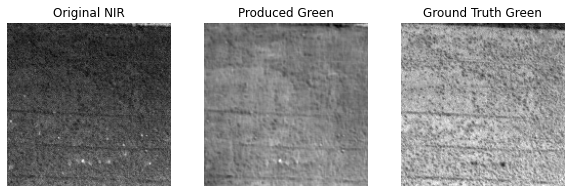

In [9]:
index = 1095
img = train_x[index:index+1, :, :, :]
img_g = train_y[index, :, :, 0]
p = model.predict(img)
p = p.squeeze()
img = img.squeeze()
print(p.shape)

img_ls = [img, p, img_g]
title = ['Original NIR', 'Produced Green', 'Ground Truth Green']
fig = plt.figure(figsize=(10,3))
for i in range(3):
    ax = fig.add_subplot(i+131)
    ax.set_title(title[i])
    ax.axis('off')
    ax.imshow(img_ls[i], cmap='gray')

### Predict Tiles & Merge 

(1280, 960)


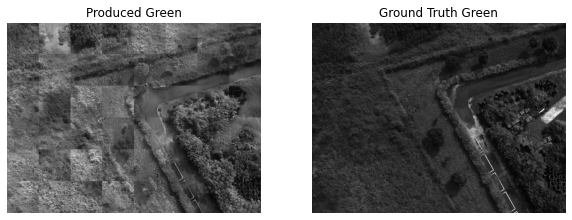

In [84]:
size = 160
index = int(960/size * 1280/size)
name = '0079'
NIR = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
green = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)

NIR = NIR/255
NIR_set = Split(NIR)
NIR_set = np.stack(NIR_set, axis=0)
NIR_set = np.expand_dims(NIR_set, axis=-1)
p = Merge(NIR_set, model.predict)
print(p.size)

img_ls = [p, green]
title = ['Produced Green', 'Ground Truth Green']
fig = plt.figure(figsize=(10,6))
for i in range(2):
    ax = fig.add_subplot(i+121)
    ax.set_title(title[i])
    ax.axis('off')
    ax.imshow(img_ls[i], cmap='gray')
    
p.save('./outputs/produced_green.tif')

### Register

In [86]:
from SIFT_and_RANSAC import SIFT, matcher, getHomography

img1 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_2.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_4.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
dummy = cv2.imread('./outputs/produced_green.tif', cv2.IMREAD_GRAYSCALE)

kp1, des1 = SIFT(img1)
kp2, des2 = SIFT(img2)
matches = matcher(des1, des2)
h = getHomography(matches, kp1, kp2)
print(h)

img = np.zeros((img1.shape[0], img1.shape[1], 3), dtype='uint8')
height, width, channels = img.shape

img[:, :, 0] = img1
img[:, :, 1] = 0 #cv2.imread('C:/Users/tmyda/Documents/UAV_color/{name}/IMG_{name}_3toIMG_{name}_2_registered.tif'.format(name=name), cv2.IMREAD_GRAYSCALE)
img[:, :, 2] = cv2.warpAffine(img2, h, (width, height))
cv2.imshow('Reg', img)
cv2.imwrite('./outputs/{}_Reg.tif'.format(name), img)

cv2.waitKey(0)
cv2.destroyAllWindows()

[[ 9.93845785e-01  2.55003515e-04  3.34201103e+01]
 [-2.55003515e-04  9.93845785e-01 -3.45442408e+01]]
